In [1]:
import torch
import numpy as np
from diffusers.training_utils import compute_snr
from diffusers import DDPMScheduler
import pickle
from piq import LPIPS
from torch.optim import AdamW
import torch.nn.functional as F
import sys
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm

DEVICE = torch.device("cuda")
NUM_CLASSES = 10

In [2]:
sys.path.append("edm")
from edm.torch_utils import misc
from edm.dnnlib import util
from edm.training.networks import EDMPrecond
from edm import generate

In [3]:
with open("edm-cifar10-32x32-cond-ve.pkl", 'rb') as f:
    mu_real = pickle.load(f)['ema'].train().to(DEVICE)
with open("edm-cifar10-32x32-cond-ve.pkl", 'rb') as f:  
    G = pickle.load(f)['ema'].train().to(DEVICE)
with open("edm-cifar10-32x32-cond-ve.pkl", 'rb') as f:
    mu_fake = pickle.load(f)['ema'].train().to(DEVICE)


for param in G.model.parameters():
    param.requires_grad = True
for param in mu_real.model.parameters():
    param.requires_grad = True
for param in mu_fake.model.parameters():
    param.requires_grad = True

In [5]:
BATCH_SIZE = 32
T = 100
lambda_reg = 0.25 #for uncond training -- 0.5
const_timestep_G = torch.tensor([T] * BATCH_SIZE, device=DEVICE)
lpips = LPIPS()

Downloading: "https://github.com/photosynthesis-team/photosynthesis.metrics/releases/download/v0.4.0/lpips_weights.pt" to /tmp/xdg_cache/torch/hub/checkpoints/lpips_weights.pt
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vgg16-397923af.pth


In [7]:
def distribution_matching_loss(mu_real, mu_fake, 
                               x, #generated output of our generator
                               class_labels,
                               t_min=int(0.02 * T), t_max=int(0.98 * T) #timestep intervals for computing distribution matching loss
                               ): 
    timestep = torch.rand(x.shape[0], device=DEVICE) * (t_max - t_min) + t_min
    noise = torch.randn_like(x) * timestep[:, None, None, None]
    noised_x = x + noise
    with torch.no_grad():
        pred_fake_x = mu_fake(noised_x, timestep, class_labels)
        pred_real_x = mu_real(noised_x, timestep, class_labels)

    weighting_factor = 1 #abs(x - pred_real_x).mean(dim=[1, 2, 3], keepdim=True), но для CIFAR-10 надо просто 1
    grad = (pred_fake_x - pred_real_x) / weighting_factor
    loss = 0.5 * F.mse_loss(x, (x - grad).detach())
    return loss


def denoising_loss(pred_x, #denoised output by mu_fake on x_t, mu_fake(x_t)
                   timestep,
                   x #fake sample generated by our one-step generator
                   ):
    weight =  1
    loss = F.mse_loss(pred_x, x, reduction="mean")
    return loss


def lpips_loss(fake_ref, #G(z), z from dataset D
               real_ref, #y from dataset D
               ):
    loss = lpips(fake_ref, real_ref)
    return loss

In [8]:
def train_step(batch, optimizer_G, optimizer_mu_fake):
    optimizer_G.zero_grad()
    optimizer_mu_fake.zero_grad()
    
    z_ref, y_ref, class_labels = batch
    bs = z_ref.shape[0]
    z = torch.randn_like(z_ref)
    x, x_ref = G(z, const_timestep_G, class_labels=class_labels), G(z_ref, const_timestep_G, class_labels=class_labels)
    # update generator
    loss_kl = distribution_matching_loss(mu_real, mu_fake, x, class_labels=class_labels)
    loss_reg = lpips_loss(x_ref, y_ref)
    loss_G = loss_kl + lambda_reg * loss_reg
    torch.nn.utils.clip_grad_norm_(G.parameters(), max_norm=10)
    loss_G.backward()
    optimizer_G.step() 
    linear_warmup_G.step()

    #update mu_fake
    timestep = torch.rand(bs, device=z_ref.device) * T
    noise = torch.randn_like(x) * timestep[:, None, None, None]
    xt = x.detach() + noise.detach() #noised x
    pred_x = mu_fake(xt, timestep, class_labels=class_labels) #pred noise
    loss_denoise = denoising_loss(pred_x, timestep, x.detach()) #не x.detach, а noise (noise.detach())?
    torch.nn.utils.clip_grad_norm_(mu_fake.parameters(), max_norm=10)
    loss_denoise.backward()
    optimizer_mu_fake.step()
    linear_warmup_mu_fake.step()
    
    return loss_G, loss_denoise

### Переобучаемся на батче

In [11]:
optimizer_G = AdamW(G.parameters(), lr=5e-5)
optimizer_mu_fake = AdamW(mu_fake.parameters(), lr=5e-5)

linear_warmup_G = torch.optim.lr_scheduler.LinearLR(optimizer_G, start_factor=0.01, total_iters=500)
linear_warmup_mu_fake = torch.optim.lr_scheduler.LinearLR(optimizer_mu_fake, start_factor=0.01, total_iters=500)

In [12]:
loss_history_G = []
loss_history_mu_fake = []

class_labels = torch.zeros(BATCH_SIZE, NUM_CLASSES, device=DEVICE)
class_labels[np.arange(BATCH_SIZE), np.random.randint(0, NUM_CLASSES, size=BATCH_SIZE)] = 1
z = torch.randn(BATCH_SIZE, 3, 32, 32, device=DEVICE)
with torch.no_grad():
    y = generate.ablation_sampler(mu_real, z, class_labels, num_steps=32, schedule="ve", scaling="none", discretization="ve", solver="heun")#huen solver for mu_real on z
batch = (z * T, y.float(), class_labels)
    
for step in tqdm(range(2001)):    
    loss_G, loss_mu_fake = train_step(batch, optimizer_G, optimizer_mu_fake)
    loss_history_G.append(loss_G.detach().cpu())
    loss_history_mu_fake.append(loss_mu_fake.detach().cpu())
    if step % 25 == 0:
        print(f"Step {step}:")
        print(f"Loss G: {loss_G}")
        print(f"Loss mu_fake: {loss_mu_fake}")
        print("----------------------------")

  0%|          | 1/2001 [00:02<1:16:12,  2.29s/it]

Step 0:
Loss G: 0.1297169178724289
Loss mu_fake: 0.02767067216336727
----------------------------


  1%|▏         | 26/2001 [00:54<1:08:57,  2.10s/it]

Step 25:
Loss G: 0.12678056955337524
Loss mu_fake: 0.023989273235201836
----------------------------


  3%|▎         | 51/2001 [01:47<1:10:09,  2.16s/it]

Step 50:
Loss G: 0.12123071402311325
Loss mu_fake: 0.024392418563365936
----------------------------


  4%|▍         | 76/2001 [02:42<1:10:13,  2.19s/it]

Step 75:
Loss G: 0.11219415813684464
Loss mu_fake: 0.017776278778910637
----------------------------


  5%|▌         | 101/2001 [03:36<1:09:31,  2.20s/it]

Step 100:
Loss G: 0.0994972288608551
Loss mu_fake: 0.0186254121363163
----------------------------


  6%|▋         | 126/2001 [04:31<1:08:46,  2.20s/it]

Step 125:
Loss G: 0.08042332530021667
Loss mu_fake: 0.010496124625205994
----------------------------


  8%|▊         | 151/2001 [05:26<1:07:49,  2.20s/it]

Step 150:
Loss G: 0.06373860687017441
Loss mu_fake: 0.015562750399112701
----------------------------


  9%|▉         | 176/2001 [06:21<1:06:52,  2.20s/it]

Step 175:
Loss G: 0.05125986039638519
Loss mu_fake: 0.007725503295660019
----------------------------


 10%|█         | 201/2001 [07:16<1:06:04,  2.20s/it]

Step 200:
Loss G: 0.04317547753453255
Loss mu_fake: 0.005963696166872978
----------------------------


 11%|█▏        | 226/2001 [08:11<1:04:55,  2.19s/it]

Step 225:
Loss G: 0.0375802218914032
Loss mu_fake: 0.004558143671602011
----------------------------


 13%|█▎        | 251/2001 [09:06<1:04:07,  2.20s/it]

Step 250:
Loss G: 0.031708844006061554
Loss mu_fake: 0.004614884965121746
----------------------------


 14%|█▍        | 276/2001 [10:01<1:03:11,  2.20s/it]

Step 275:
Loss G: 0.03071896918118
Loss mu_fake: 0.0024304715916514397
----------------------------


 15%|█▌        | 301/2001 [10:56<1:02:24,  2.20s/it]

Step 300:
Loss G: 0.027007516473531723
Loss mu_fake: 0.0018596926238387823
----------------------------


 16%|█▋        | 326/2001 [11:51<1:01:29,  2.20s/it]

Step 325:
Loss G: 0.025160055607557297
Loss mu_fake: 0.002486715791746974
----------------------------


 18%|█▊        | 351/2001 [12:46<1:00:31,  2.20s/it]

Step 350:
Loss G: 0.022734547033905983
Loss mu_fake: 0.0033711432479321957
----------------------------


 19%|█▉        | 376/2001 [13:41<59:35,  2.20s/it]  

Step 375:
Loss G: 0.02001570537686348
Loss mu_fake: 0.0027368739247322083
----------------------------


 20%|██        | 401/2001 [14:36<58:39,  2.20s/it]

Step 400:
Loss G: 0.0185282863676548
Loss mu_fake: 0.0026784453075379133
----------------------------


 21%|██▏       | 426/2001 [15:31<57:36,  2.19s/it]

Step 425:
Loss G: 0.016275674104690552
Loss mu_fake: 0.0022785200271755457
----------------------------


 23%|██▎       | 451/2001 [16:26<56:52,  2.20s/it]

Step 450:
Loss G: 0.015559046529233456
Loss mu_fake: 0.002497313544154167
----------------------------


 24%|██▍       | 476/2001 [17:21<55:51,  2.20s/it]

Step 475:
Loss G: 0.014599088579416275
Loss mu_fake: 0.0020984546281397343
----------------------------


 25%|██▌       | 501/2001 [18:16<54:53,  2.20s/it]

Step 500:
Loss G: 0.015641972422599792
Loss mu_fake: 0.0016442224150523543
----------------------------


 26%|██▋       | 526/2001 [19:11<53:59,  2.20s/it]

Step 525:
Loss G: 0.01191015262156725
Loss mu_fake: 0.0016981714870780706
----------------------------


 28%|██▊       | 551/2001 [20:06<53:10,  2.20s/it]

Step 550:
Loss G: 0.011776801198720932
Loss mu_fake: 0.0012922956375405192
----------------------------


 29%|██▉       | 576/2001 [21:01<52:09,  2.20s/it]

Step 575:
Loss G: 0.011208551004529
Loss mu_fake: 0.0012076690327376127
----------------------------


 30%|███       | 601/2001 [21:56<51:16,  2.20s/it]

Step 600:
Loss G: 0.011465733870863914
Loss mu_fake: 0.001159339095465839
----------------------------


 31%|███▏      | 626/2001 [22:51<50:24,  2.20s/it]

Step 625:
Loss G: 0.011110352352261543
Loss mu_fake: 0.0010089738061651587
----------------------------


 33%|███▎      | 651/2001 [23:46<49:29,  2.20s/it]

Step 650:
Loss G: 0.012862637639045715
Loss mu_fake: 0.0009028750355355442
----------------------------


 34%|███▍      | 676/2001 [24:41<48:35,  2.20s/it]

Step 675:
Loss G: 0.009977834299206734
Loss mu_fake: 0.0009379381081089377
----------------------------


 35%|███▌      | 701/2001 [25:35<47:37,  2.20s/it]

Step 700:
Loss G: 0.012533213011920452
Loss mu_fake: 0.0007859664037823677
----------------------------


 36%|███▋      | 726/2001 [26:30<46:38,  2.20s/it]

Step 725:
Loss G: 0.010334381833672523
Loss mu_fake: 0.0006927801296114922
----------------------------


 38%|███▊      | 751/2001 [27:25<45:49,  2.20s/it]

Step 750:
Loss G: 0.012391313910484314
Loss mu_fake: 0.0007051338325254619
----------------------------


 39%|███▉      | 776/2001 [28:20<45:01,  2.21s/it]

Step 775:
Loss G: 0.01161907333880663
Loss mu_fake: 0.000652765273116529
----------------------------


 40%|████      | 801/2001 [29:15<43:57,  2.20s/it]

Step 800:
Loss G: 0.00928090326488018
Loss mu_fake: 0.0005606766208074987
----------------------------


 41%|████▏     | 826/2001 [30:10<43:10,  2.20s/it]

Step 825:
Loss G: 0.0114900516346097
Loss mu_fake: 0.0005973706720396876
----------------------------


 43%|████▎     | 851/2001 [31:05<42:08,  2.20s/it]

Step 850:
Loss G: 0.012295426800847054
Loss mu_fake: 0.0005905504222027957
----------------------------


 44%|████▍     | 876/2001 [32:00<41:06,  2.19s/it]

Step 875:
Loss G: 0.009575879201292992
Loss mu_fake: 0.0005160485743544996
----------------------------


 45%|████▌     | 901/2001 [32:55<40:13,  2.19s/it]

Step 900:
Loss G: 0.011959344148635864
Loss mu_fake: 0.0004873442812822759
----------------------------


 46%|████▋     | 926/2001 [33:50<39:25,  2.20s/it]

Step 925:
Loss G: 0.010522720403969288
Loss mu_fake: 0.0004931878647767007
----------------------------


 48%|████▊     | 951/2001 [34:45<38:29,  2.20s/it]

Step 950:
Loss G: 0.010819998569786549
Loss mu_fake: 0.0005119068082422018
----------------------------


 49%|████▉     | 976/2001 [35:40<37:24,  2.19s/it]

Step 975:
Loss G: 0.011896302923560143
Loss mu_fake: 0.00047686806647107005
----------------------------


 50%|█████     | 1001/2001 [36:35<36:33,  2.19s/it]

Step 1000:
Loss G: 0.01122310571372509
Loss mu_fake: 0.00041433877777308226
----------------------------


 51%|█████▏    | 1026/2001 [37:30<35:45,  2.20s/it]

Step 1025:
Loss G: 0.010176376439630985
Loss mu_fake: 0.0004700572171714157
----------------------------


 53%|█████▎    | 1051/2001 [38:25<34:53,  2.20s/it]

Step 1050:
Loss G: 0.010408468544483185
Loss mu_fake: 0.0004080657381564379
----------------------------


 54%|█████▍    | 1076/2001 [39:20<33:51,  2.20s/it]

Step 1075:
Loss G: 0.008759688585996628
Loss mu_fake: 0.00043229953735135496
----------------------------


 55%|█████▌    | 1101/2001 [40:15<32:57,  2.20s/it]

Step 1100:
Loss G: 0.008869958110153675
Loss mu_fake: 0.0003576695453375578
----------------------------


 56%|█████▋    | 1126/2001 [41:10<32:06,  2.20s/it]

Step 1125:
Loss G: 0.012728714384138584
Loss mu_fake: 0.0003247382992412895
----------------------------


 58%|█████▊    | 1151/2001 [42:05<31:12,  2.20s/it]

Step 1150:
Loss G: 0.010987766087055206
Loss mu_fake: 0.00040651982999406755
----------------------------


 58%|█████▊    | 1155/2001 [42:15<30:57,  2.20s/it]


KeyboardInterrupt: 

In [13]:
torch.save(G.state_dict(), "G_1batch.pth")

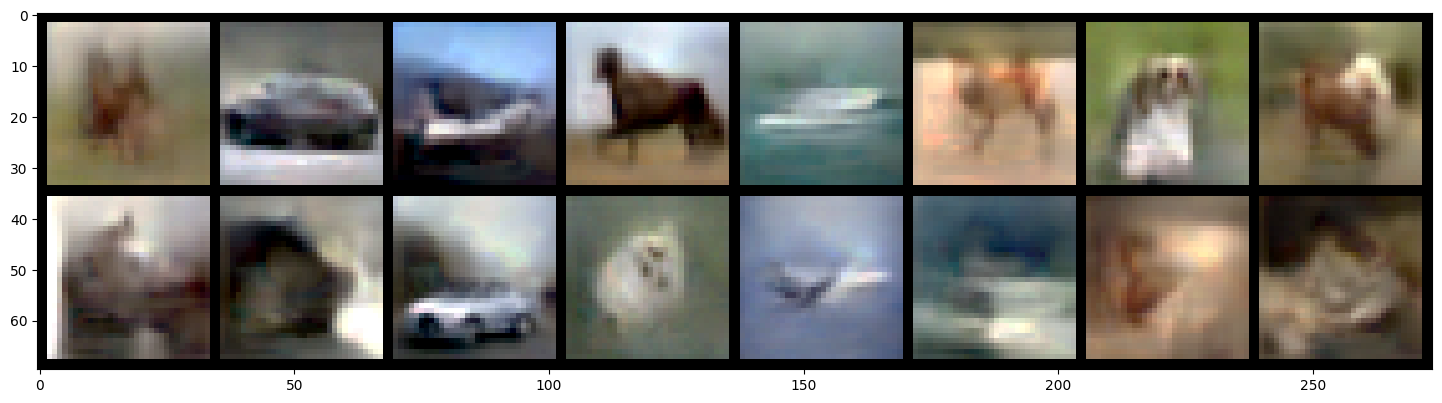

In [49]:
from torchvision.utils import make_grid
def normalize(x):
    return x / x.abs().max(dim=0)[0][None, ...]

z_random = torch.randn(BATCH_SIZE, 3, 32, 32, device=DEVICE)
plt.figure(figsize=[18, 10])
out = G(z_random * T, const_timestep_G, class_labels=class_labels)
norm_factor = out.abs().max(dim=(0)).values[None, ...]
plt.imshow(make_grid((normalize(out)[:16] + 1) / 2).cpu().permute(1, 2, 0).detach().numpy())

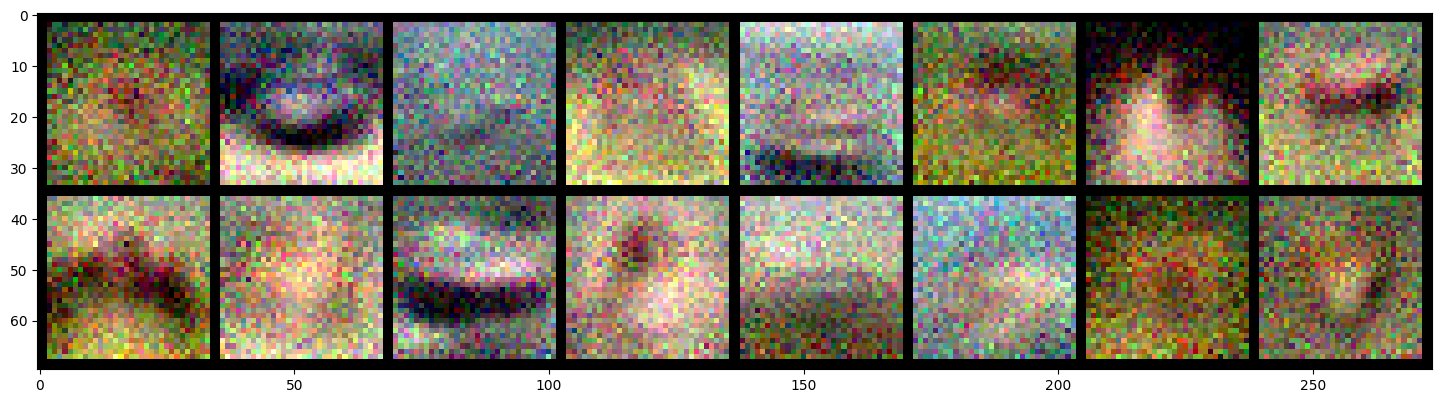

In [52]:
from torchvision.utils import make_grid
def normalize(x):
    return x / x.abs().max(dim=0)[0][None, ...]

plt.figure(figsize=[18, 10])
out = mu_real(z_random * T, const_timestep_G, class_labels=class_labels)
plt.imshow(make_grid((normalize(out)[:16] + 1) / 2).cpu().permute(1, 2, 0).detach().numpy())

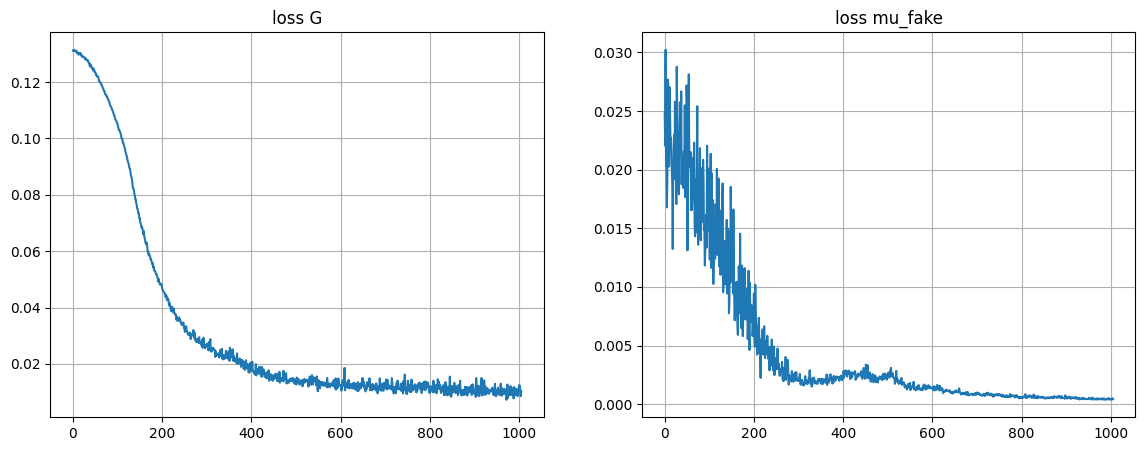

In [18]:
f, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(loss_history_G)
axs[0].grid(True)
axs[0].set_title("loss G")

axs[1].plot(loss_history_mu_fake)
axs[1].grid(True)
axs[1].set_title("loss mu_fake")
plt.show()

### Обучаемся как на батче

In [9]:
noise_dataset = torch.load("dataset/noise.pt")
class_labels_dataset = torch.load("dataset/class_labels.pt")
y_dataset = torch.load("dataset/y.pt")

In [10]:
from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(noise_dataset, y_dataset, class_labels_dataset)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
def plot_losses(loss_history_G, loss_history_mu_fake):
    f, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(loss_history_G)
    axs[0].grid(True)
    axs[0].set_title("loss G")

    axs[1].plot(loss_history_mu_fake)
    axs[1].grid(True)
    axs[1].set_title("loss mu_fake")
    plt.show()

Unknown instance spec: Please select VM configuration

Step 4500:
Loss G: 0.015867624431848526
Loss mu_fake: 0.0001538169162813574
----------------------------


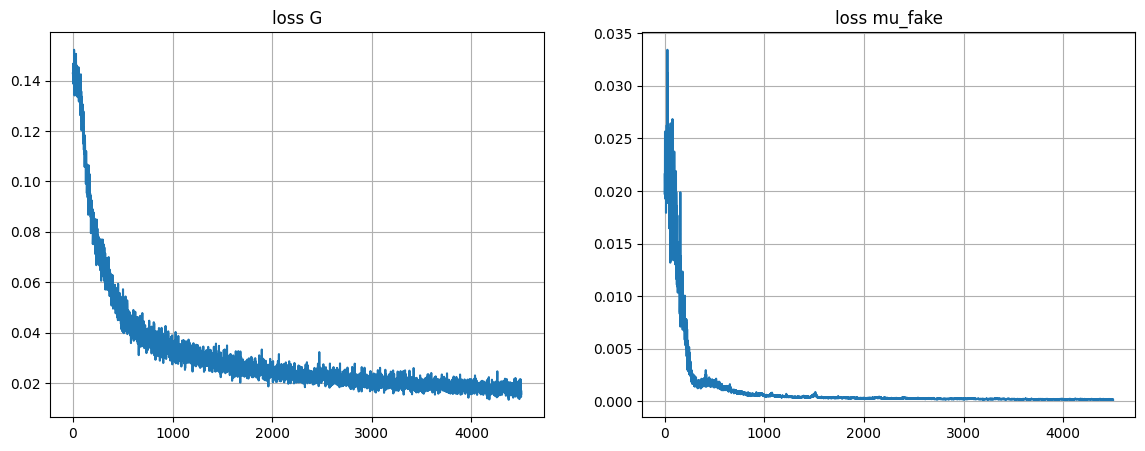

 43%|████▎     | 6831/16001 [4:06:31<5:30:47,  2.16s/it]

In [ ]:
from IPython.display import clear_output
loss_history_G = []
loss_history_mu_fake = []

optimizer_G = AdamW(G.parameters(), lr=5e-5)
optimizer_mu_fake = AdamW(mu_fake.parameters(), lr=5e-5)

linear_warmup_G = torch.optim.lr_scheduler.LinearLR(optimizer_G, start_factor=0.01, total_iters=500)
linear_warmup_mu_fake = torch.optim.lr_scheduler.LinearLR(optimizer_mu_fake, start_factor=0.01, total_iters=500)
    
data_iter = iter(dataloader) 
for step in tqdm(range(16001)):    
    try:
        batch = next(data_iter) 
    except StopIteration:
        data_iter = iter(dataloader)
        batch = next(data_iter)
    batch[0] = (batch[0] * T).to(DEVICE)
    batch[1] = batch[1].float().to(DEVICE)
    batch[2] = batch[2].to(DEVICE)
    loss_G, loss_mu_fake = train_step(batch, optimizer_G, optimizer_mu_fake)
    loss_history_G.append(loss_G.detach().cpu())
    loss_history_mu_fake.append(loss_mu_fake.detach().cpu())
    if step % 100 == 0:
        clear_output(wait=True)
        print(f"Step {step}:")
        print(f"Loss G: {loss_G}")
        print(f"Loss mu_fake: {loss_mu_fake}")
        print("----------------------------")
        plot_losses(loss_history_G, loss_history_mu_fake)
    if step % 4000 == 0:
        torch.save({
            'step': step,
            'model_state_dict': G.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict(),
            'loss': loss_G,
        }, f"model_weights/model_G_{step}steps.pt")
        torch.save({
            'step': step,
            'model_state_dict': mu_fake.state_dict(),
            'optimizer_state_dict': optimizer_mu_fake.state_dict(),
            'loss': loss_mu_fake,
        }, f"model_weights/model_mu_fake_{step}steps.pt")